In [1]:
import tensorflow as tf ##pip install tensorflow-gpu
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [15]:
img_array = cv2.imread("dataset/Mask/00000_Mask.jpg")

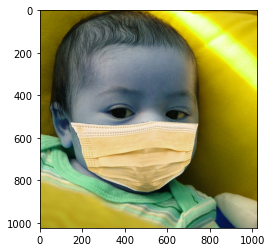

In [16]:
plt.imshow(img_array)  ##BGR

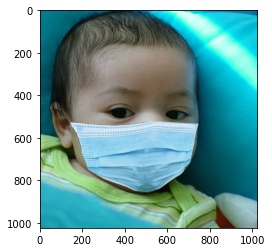

In [17]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

In [18]:
img_array.shape
#RGB channel 3

(1024, 1024, 3)

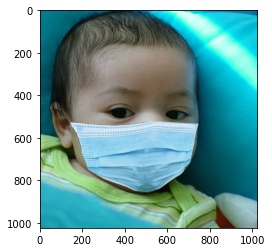

In [2]:
data_directory = "dataset/" ## training dataset
Classes = ["Mask","No_Mask"] ##list of classes
for category in Classes:
    path = os.path.join(data_directory, category) 
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        #backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

In [3]:
img_array.shape

(1024, 1024, 3)

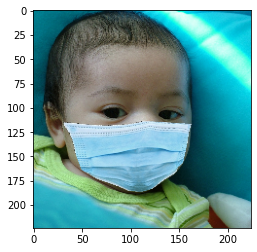

In [3]:
img_size = 224 #224 x 224

new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#reading the images & converting all to array

In [4]:
training_Data = [] ## data
def create_training_Data():
    for category in Classes:
        path = os.path.join(data_directory, category)
        class_num = Classes.index(category) ## 0 1 ## labels
        for img in os.listdir(path):
            try:
                #read from file
                img_array = cv2.imread(os.path.join(path, img))
                #resize image
                new_array = cv2.resize(img_array, (img_size, img_size))
                #appending the list, image and the class number
                training_Data.append([new_array, class_num]) 
            except Exception as e:
                pass

In [5]:
create_training_Data() # execute the function

In [6]:
print(len(training_Data)) #check the images trained in both files
#balance/close, the total number of images in both files
#1948 images from both Mask and No_Mask file

3865


In [7]:
import random
random.shuffle(training_Data) #preventing overfitted
# we dont bother the sequence of the images

In [8]:
X = [] ## data /feature
y = [] ## label

for features,label in training_Data:
    #appending the features and label
    X.append(features)
    y.append(label)
#(all the size of the images, 3 = rgb channel)
#all of the dataset is in numpy array, prev it was list
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [9]:
X.shape #(1951, 224, 224, 3)

(3865, 224, 224, 3)

In [10]:
#normalize the data
#max value of grey is 255
X = X/255.0; 

In [11]:
#converting 1, 0 label which in list to numpy array
Y = np.array(y)

In [12]:
#store data in pickle
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

#save until here for the pre processing of the image

In [13]:
#after close all/save all, just run this code
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

In [ ]:
#deep learning model for training - Transfer learning

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
#pre-trained model
model = tf.keras.applications.mobilenet.MobileNet()
#mobilenet = a good lightweight for this project


In [16]:
#many layers, 4.2 million parameters
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
#transfer learning - Tuning, weights will start from last check point

In [ ]:
#need to modify last three layer (dropout, conv2D, reshape, activation)

In [18]:
base_input = model.layers[0].input

In [19]:
#cut the last 4 layers, -4
base_output = model.layers[-4].output

In [20]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) ##binary classifier, 0, 1, facemask/not
final_output = layers.Activation('sigmoid')(final_output) ##we use sigmoid


In [21]:
new_model = keras.Model(inputs = base_input, outputs = final_output)


In [22]:
new_model.summary()
#3.2 million params, dense = 1
# we reduced the params
#only one neuron in the last dense layer

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
#settings for binary classification (Mask/No Mask)

In [23]:
#make nodes
#we used the sigmoid, id use softMax = sparse_entropy etc
#but this is binary case, optimizer, the most famous is 'adam', for softmax too

new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [24]:
#training deep learning module
new_model.fit(X,Y, epochs = 5, validation_split = 0.1)

Epoch 1/5
109/109 [==============================] - 1009s 9s/step - loss: 0.0757 - accuracy: 0.9776 - val_loss: 0.1777 - val_accuracy: 0.9664
Epoch 2/5
109/109 [==============================] - 669s 6s/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.0494 - val_accuracy: 0.9897
Epoch 3/5
109/109 [==============================] - 661s 6s/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 0.1320 - val_accuracy: 0.9690
Epoch 4/5
109/109 [==============================] - 657s 6s/step - loss: 0.0119 - accuracy: 0.9951 - val_loss: 0.0413 - val_accuracy: 0.9871
Epoch 5/5
109/109 [==============================] - 655s 6s/step - loss: 0.0256 - accuracy: 0.9928 - val_loss: 0.2529 - val_accuracy: 0.9793


In [ ]:
#maybe do not need some layer, want to freeze some layers
#frozen = not  modify the weight of that particular layer
#for layer in model.layer:
    #going to freeze all the layers
    #layer.trainable = false
    #going to freeze choosen layers
    #layer[].trainable
    
#freezing single layer 0, 1, 3, 4...
#model.layer[0].trainable = false

#validation accuracy 63, with first epoch
#usually very less, will try to change the epoch value until 5
#until get 95 to 97 percent accurate then stop

In [25]:
new_model.save('my_model3.h5')

In [26]:
#way to load the previous model
new_model = tf.keras.models.load_model("my_model3.h5")

In [ ]:
#checking the network for predictions

In [27]:
#read one image to test
frame = cv2.imread("dataset2/photo_NUR AISYAH BINTI MD ISA.jpg")

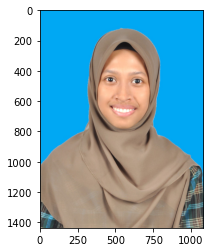

In [28]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#dimension of the image is too large
#need to resize to 4 dimension (shape) = 1951, 224, 244, 3
#because of depth wise device conversion neural network
#just assume that we need 4 dimensions, by doing -1, during the numpy array



In [29]:
final_image = cv2.resize(frame, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) #need fourth dimension
final_image = final_image/255.0 #normalizing the data


In [30]:
Predictions = new_model.predict(final_image)

In [31]:
Predictions
#have facemask -ve value
#have no facemask +ve value


array([[0.9996544]], dtype=float32)

In [ ]:
#checking the network for unknown images

In [32]:
#read one image to test
frame = cv2.imread("dataset2/photo_NUR AISYAH BINTI MD ISA masked.png")

In [34]:
frame.shape
#3 dimension

(2245, 1587, 3)

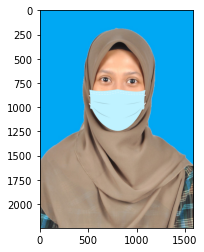

In [35]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


In [36]:
#haar cascade face detection xml
#frontal face, feature detector use to detect the face
#pre stored faces
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [37]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [38]:
#check size
gray.shape
#2 dimensions


(2245, 1587)

In [39]:
#to detect the full corner of the face
faces = faceCascade.detectMultiScale(gray, 1.1,4)
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w,y+h),(255,0,0),2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess)==0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in facess:
            #cropping the face
            face_roi = roi_color[ey:ey+eh, ex:ex+ew]

Face not detected


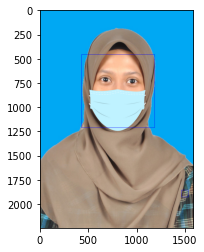

In [40]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#putting rectangle

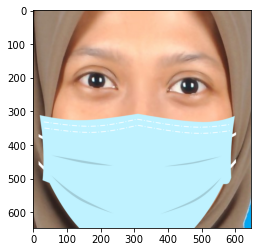

In [41]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
#show cropped face

In [42]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) #need fourth dimension
final_image = final_image/255.0 #normalizing the data


In [43]:
Predictions = new_model.predict(final_image)

In [44]:
Predictions
#negative because of the sigmoid function

array([[8.313382e-15]], dtype=float32)

In [45]:
import cv2
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN


    
    
    

In [46]:
#set the rectanle background to white
rectangle_bgr = (255, 255, 255)
#make a black image
img = np.zeros((500, 500))
#set some text
text = "Some text in a box"
#get the width and height of the box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale = font_scale, thickness = 1) [0]
#set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
#make the coords of the box with a small padding of the two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0,0,0), thickness = 1)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
cap = cv2.VideoCapture(1)
#check if webcam is on
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError ("Webcam cannot be switched on")

while True:
    ret, frame = cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    
    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        #draw rectangle on the face
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face is not detected")
        else:
            for(ex, ey, ew, eh) in facess:
                #cropping the image, only face in the rectangle
                face_roi = roi_color[ey: ey+eh, ex: ex+ew]
                
    #resize the image
    final_image = cv2.resize(face_roi, (224,224))
    
    #normalizing
    final_image = np.expand_dims(final_image, axis = 0) #for 4th dimension
    final_image = final_image/255.0
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if (Predictions > 0.9):
        status = "No Mask"
        x1, y1, w1, h1 = 0,0,175,75
        
        #draw black background rectangle
        cv2.rectangle(frame,(x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
    else:
        status = "Face Mask"
        x1, y1, w1, h1 = 0,0,175,75
        
        #draw black background rectangle
        cv2.rectangle(frame,(x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0,255,0), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,255,0))
    
    cv2.imshow("Face Mask Detection", frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not detected
Face is not d